In [ ]:
# ArcFace loss function
import tensorflow as tf

def arcface_loss(y_true, y_pred, margin=0.5, scale=64):
    y_pred = tf.clip_by_value(y_pred, -1.0 + 1e-7, 1.0 - 1e-7)
    theta = tf.acos(y_pred)
    target_logits = scale * tf.cos(theta + margin)
    other_logits = scale * tf.cos(theta)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=tf.where(tf.cast(y_true, dtype=tf.bool), target_logits, other_logits)
    ))


In [ ]:
# Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
DATA_PATH = '/content/drive/MyDrive/test_vggface'

def create_data_generator(data_path, img_height, img_width, batch_size):
    data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

    train_gen = data_generator.flow_from_directory(
        data_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return train_gen

train_gen = create_data_generator(DATA_PATH, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)


Found 3846 images belonging to 10 classes.


In [ ]:
# Model Architecture
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512)(x)
    x = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=1))(x)  # ArcFace-specific layer

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = 10  # Change based on your dataset
model = build_model(input_shape, num_classes)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Training Process
def train_model(model, train_gen, epochs, arcface_loss_func):
    model.compile(optimizer='adam', loss=arcface_loss_func, metrics=['accuracy'])

    model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        epochs=epochs
    )

train_model(model, train_gen, epochs=10, arcface_loss_func=arcface_loss)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 3946s 30s/step - accuracy: 0.5844 - loss: 27.3565
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7500 - loss: 18.5403 
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.7118 - loss: 17.5839
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.8438 - loss: 11.6653 
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.8059 - loss: 12.2283
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - accuracy: 0.8125 - loss: 10.7061 
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.8391 - loss: 10.4674
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.8438 - loss: 9.7977 
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 307ms/step - accuracy: 0.8775 - loss: 7.9607
Epoch 10/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.8750 - loss: 6.1213 


In [ ]:
# prompt: give me code to print accuracy

loss, accuracy = model.evaluate(train_gen)
print('Accuracy:', accuracy)


121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.8916 - loss: 6.7844
Accuracy: 0.8923556804656982


In [ ]:
model.save('/content/drive/MyDrive/models_face_recognition/arcface_2.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


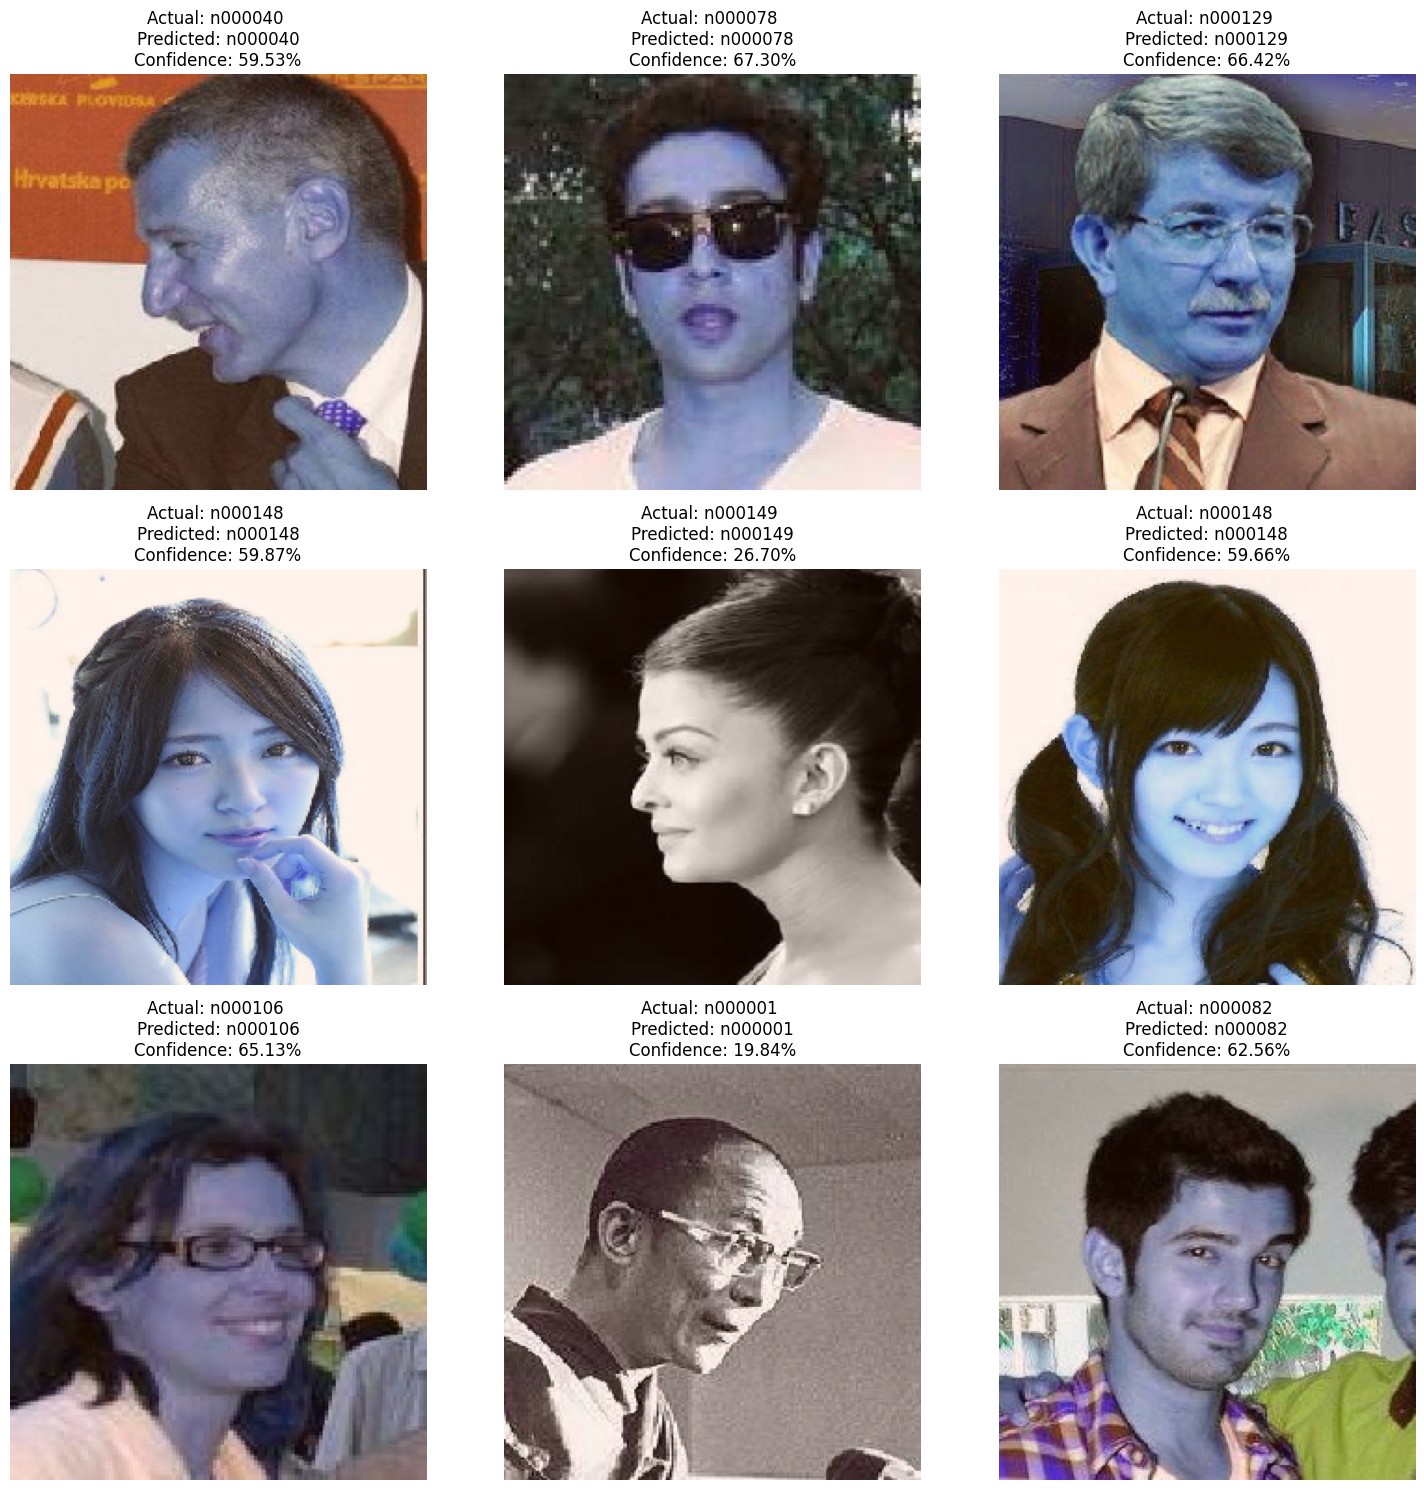

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def predict_random_images(generator, model, num_images=9):
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    total_batches = len(generator)
    num_batches = (num_images + generator.batch_size - 1) // generator.batch_size

    random_batches = random.sample(range(total_batches), num_batches)
    images, actual_labels, predicted_classes, confidences = [], [], [], []

    for batch_idx in random_batches:
        batch_images, batch_labels = generator[batch_idx]
        predictions = model.predict(batch_images)

        for i in range(len(batch_images)):
            if len(images) >= num_images:
                break
            # Append the images and predictions to lists
            images.append(batch_images[i])
            actual_labels.append(batch_labels[i])
            predicted_class = np.argmax(predictions[i])
            predicted_classes.append(predicted_class)
            confidences.append(np.max(predictions[i]) * 100)

    # Plot the images and predictions
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)

        # Scale images back to [0, 255] for proper display
        img_display = images[i]
        img_display = (img_display - np.min(img_display)) / (np.max(img_display) - np.min(img_display))  # Normalize to [0, 1]
        img_display = np.clip(img_display, 0, 1)  # Ensure no values go out of bounds

        plt.imshow(img_display)
        plt.title(f"Actual: {class_names[np.argmax(actual_labels[i])]} \n"
                  f"Predicted: {class_names[predicted_classes[i]]}\n"
                  f"Confidence: {confidences[i]:.2f}%")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example Usage
predict_random_images(train_gen, model, num_images=9)
